In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from data.dataset import MoonCometTranslateBMELDataset
from torch.utils.data import DataLoader
from pathlib import Path
import torch
import matplotlib.pyplot as plt

import core.praser as Praser
from models.network import Network


In [3]:
DEVICE = 'cuda:2'
EPOCH = 260
EMA = '_ema'
ROOT = 'experiments/'
ROOT += 'train_colorization_fastmri_230816_144807/'

In [4]:
args = Namespace(config=ROOT + 'config.json', phase='test', gpu_ids=None, batch=6, debug=False)
opt = Praser.parse_test(args)

In [5]:
model_args = opt["model"]["which_networks"][0]["args"]
model = Network(**model_args)
model_pth = Path(ROOT) / 'checkpoint' / f'{EPOCH}_Network{EMA}.pth'
state_dict = torch.load(model_pth)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.set_new_noise_schedule(device=DEVICE, phase='test')

In [6]:
ds = MoonCometTranslateBMELDataset()
dl = DataLoader(ds, batch_size=args.batch)

SliceDataset.tx: 100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


sampling loop time step: 100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]


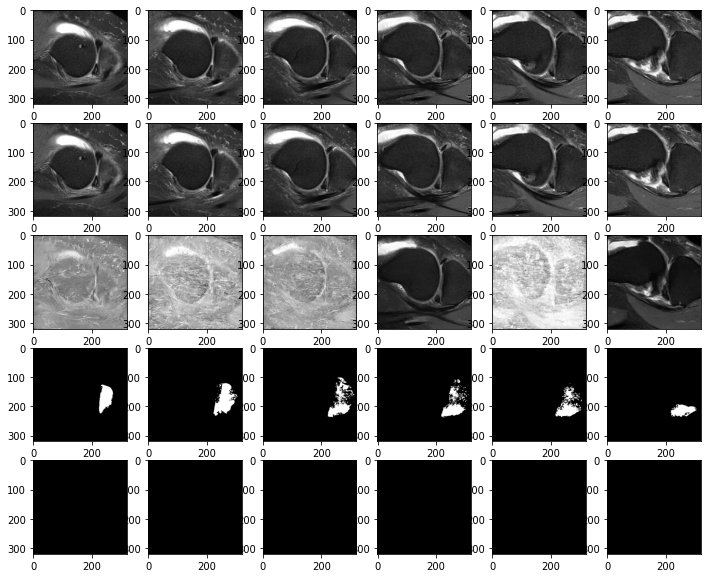

In [9]:
ret = {}
for batch in dl:
    batch_size = len(batch['path'])
    model.output, model.visuals = model.restoration(
        batch['cond_image'].to(DEVICE),
        # y_t=batch['cond_image'].to(DEVICE),
        # y_0=batch['gt_image'].to(DEVICE),
        sample_num=8
    )

    fig, ax = plt.subplots(5, batch_size, figsize=(20 * batch_size / 5, 20))
    for ndx in range(batch_size):
        sample = {
            'cond': batch['cond_image'][ndx,0],
            'gt': batch['gt_image'][ndx,0],
            'pred': model.output[ndx,0].cpu(),
            'bmel': batch['bmel'][ndx,0],
        }
        # ret[batch['path'][ndx]] = sample
        im = ax[0,ndx].imshow(sample['cond'], 'gray')
        plt.colorbar(im, ax=ax[0,ndx])
        im = ax[1,ndx].imshow(sample['gt'], 'gray')
        plt.colorbar(im, ax=ax[1,ndx])
        im = ax[2,ndx].imshow(sample['pred'], 'gray')
        plt.colorbar(im, ax=ax[2,ndx])
        im = ax[3,ndx].imshow(sample['bmel'], 'gray')
        plt.colorbar(im, ax=ax[3,ndx])
        im = ax[4,ndx].imshow(sample['gt'] - sample['cond'] > 1, 'gray')
        plt.colorbar(im, ax=ax[4,ndx])
    plt.show()

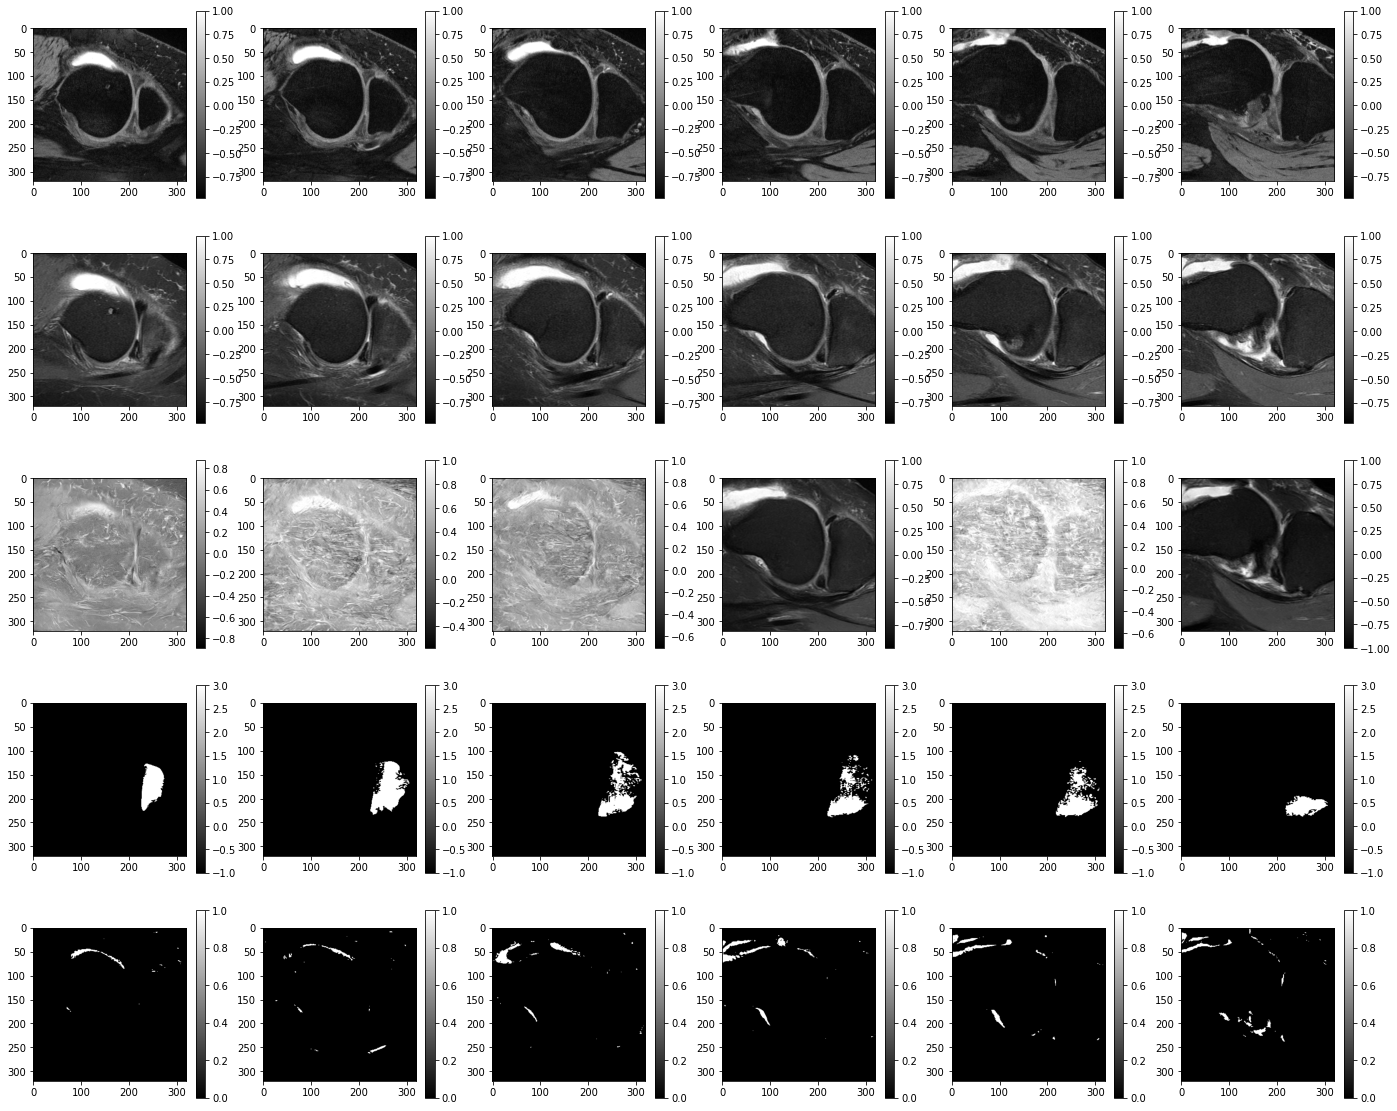